# 0.0 IMPORTS

In [1]:
import math
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from IPython.display      import Image
from IPython.core.display import HTML
from matplotlib import pyplot as plt


### 0.1 Helper Functions

In [37]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
 

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on = 'Store')

# 1.0. PASSO 1 - DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old =[ 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x : inflection.underscore( x )
cols_new = list( map( snakecase,cols_old ) )

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [8]:
df1['date']=pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
# competition_distance    
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month 
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

# competition_open_since_year  
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)
                  
# promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'],axis=1)

# promo2_since_year            
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'],axis=1)

# promo_interval 
month_map = {  1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec' }

df1['promo_interval'].fillna( 0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)


## 1.6 Change Types

In [12]:
# df1.dtypes

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype("int64")
df1['promo2_since_week'] = df1['promo2_since_week'].astype("int64")
df1['promo2_since_year'] = df1['promo2_since_year'].astype("int64")


## 1.7 Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

## 1.7.1 Numerical attributes

In [15]:
# Central Tendency -  media e mediana - são metricas de tendência central (central tendency)
ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply(np.median)).T

# Dispersion - desvio padrão, variância, range. min, max, skew, curtosis  - são metricas de dispersão
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() -  x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew() ) ).T
d6= pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis() ) ).T
                  
#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','Kurtosis',]

In [16]:
m

,attributes,min,max,range,mean,median,std,skew,Kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [17]:
# plt.figure(figsize=(15, 8));
# sns.distplot(df1['sales'])
# sns.set()

## 1.7.2 Categorical Attributes

In [18]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

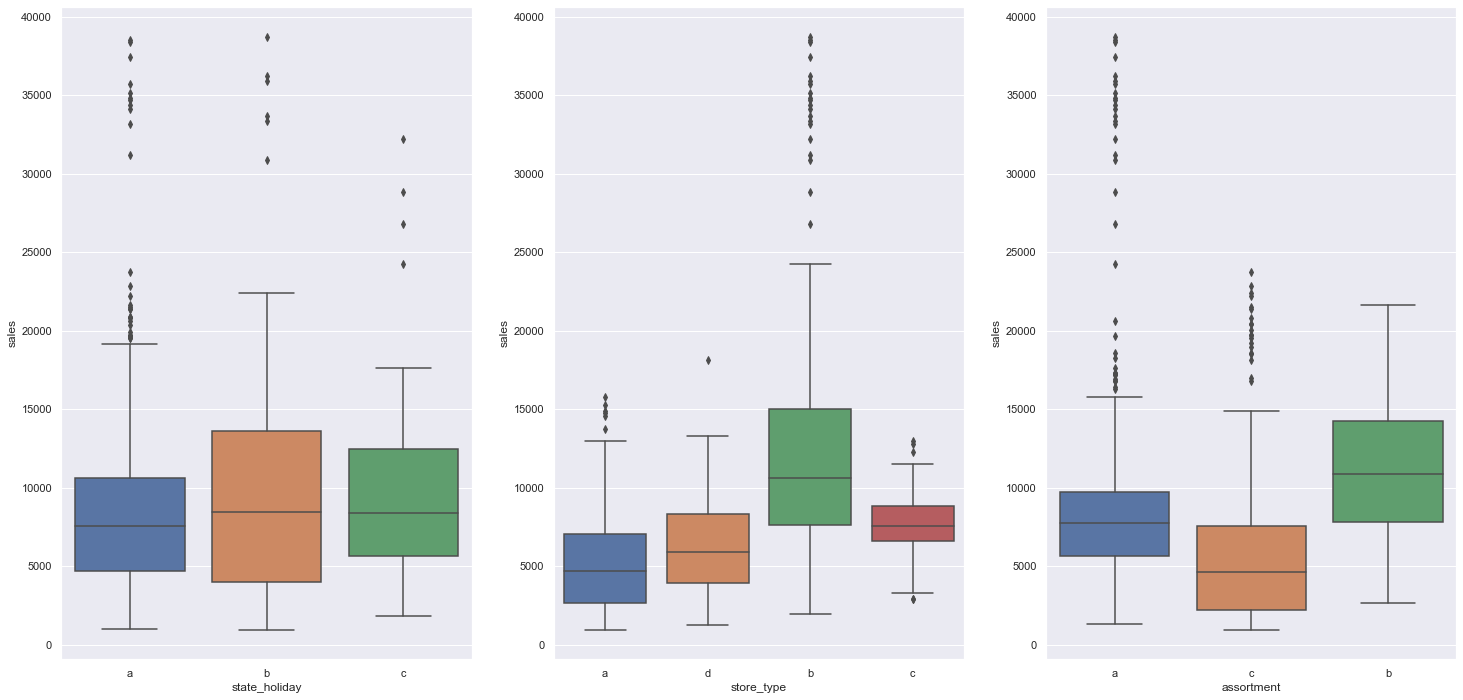

In [19]:

aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday' , y='sales' ,data=aux1 )

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type' , y='sales' ,data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment' , y='sales' ,data=aux1 )

# 2.0. PASSO 2 - FEATURE ENGINEERING

In [20]:
df2= df1.copy()

## 2.1 Mapa mental de Hipóteses

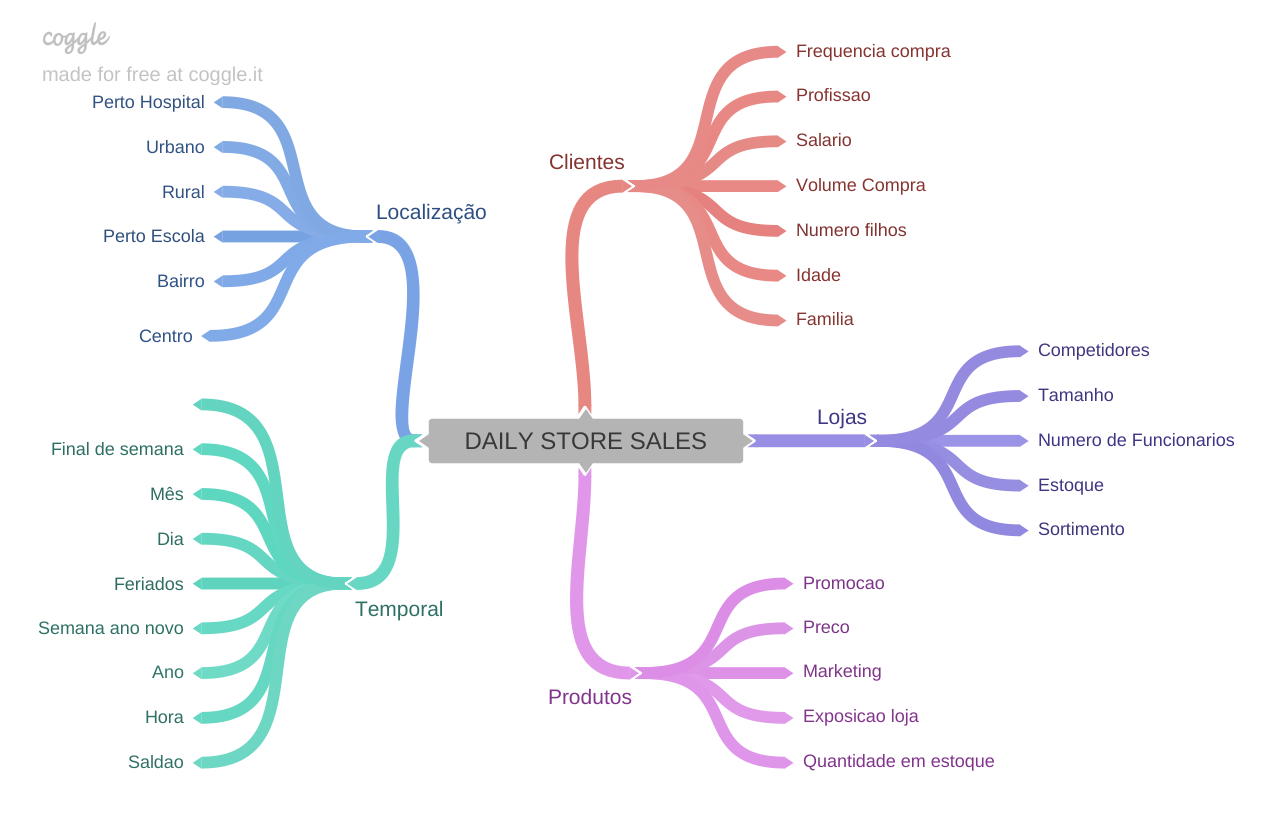

In [21]:
Image('img\MindMapHypotesis.png')

## 2.2 Criaçao das Hipóteses

### 2.1.1. Hipoteses Lojas

**1** Lojas com maior número de funcionários deveriam vender mais.

**2** Lojas com maior capacidade de estique deveriam vender mais.

**3** Lojas com maior porte deveriam vender mais.

**4** Lojas com maior sortimento deveriam vender mais.

**5** Lojas com competidores mais próximos deveriam vender menos.

**6** Lojas com maior competidores a mais tempo deveriam vender mais.

### 2.1.2. Hipoteses Produtos

**1** Lojas que investem mais em marketing deveriam vender mais.

**2** Lojas com exposição de produto deveriam vender mais.

**3** Lojas com produtos com menor preço deveriam vender mais.

**4** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6** Lojas com mais dias de promoção deveriam vender mais.

**7** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipoteses Tempo

**1** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2** Lojas deveriam vender mais ao longo dos anos.

**3** Lojas deveriam vender mais no segundo semestre do ano.

**4** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6** Lojas deveriam vender menos aos finais de semana.

**7** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipósteses

**1** Lojas com maior sortimento deveriam vender mais.

**2** Lojas com competidores mais próximos deveriam vender menos.

**3** Lojas com maior competidores a mais tempo deveriam vender mais.

**4** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5** Lojas com mais dias de promoção deveriam vender mais.

**6** Lojas com mais promoções consecutivas deveriam vender mais.

**7** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8** Lojas deveriam vender mais ao longo dos anos.

**9** Lojas deveriam vender mais no segundo semestre do ano.

**10** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11** Lojas com promoções ativas por mais tempo deveriam vender mais.

**12** Lojas deveriam vender menos aos finais de semana.

**13** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [22]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear


# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] , month= x['competition_open_since_month'], day= 1 ), axis=1 )

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))

df2['promo_time_week'] =  ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assorment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x== 'b' else 'christmas' if x =='c' else 'regular_day')

C:\Users\vande\AppData\Local\Temp\ipykernel_14788\542461104.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0. PASSO 3 - FILTRAGEM DE VARIÁVEIS

In [23]:
df3=df2.copy()

In [24]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [25]:
df3 = df3[(df3['open']!= 0) & (df3['sales'] > 0)]

## 3.2. Seleção da colunas

In [26]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

In [27]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [28]:
df3.sample(5)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
734555,556,3,2013-09-11,6924,1,regular_day,0,d,extended,1140.0,11,2014,0,37,2013,0,2013,9,11,37,2013-36,2014-11-01,-14,2013-09-09,0
144612,778,2,2015-03-24,5192,0,regular_day,0,a,basic,340.0,6,2003,1,40,2014,0,2015,3,24,13,2015-12,2003-06-01,143,2014-09-29,25
233056,22,6,2015-01-03,3007,0,regular_day,0,a,basic,1040.0,1,2015,1,22,2012,1,2015,1,3,1,2015-00,2015-01-01,0,2012-05-21,136
238290,48,1,2014-12-29,4075,0,regular_day,1,a,basic,1060.0,5,2012,0,1,2014,0,2014,12,29,1,2014-52,2012-05-01,32,2013-12-30,52
79054,1005,5,2015-05-22,6699,1,regular_day,0,a,basic,6480.0,5,2015,0,21,2015,0,2015,5,22,21,2015-20,2015-05-01,0,2015-05-18,0


# 4.0. PASSO 4 - ANÁLISE EXPLORATÓRIA DE DADOS

In [29]:
df4 = df3.copy()

## 4.1 Analise Univariada 

### 4.1.1 Response variable

C:\Users\vande\anaconda3\envs\ds-em-producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

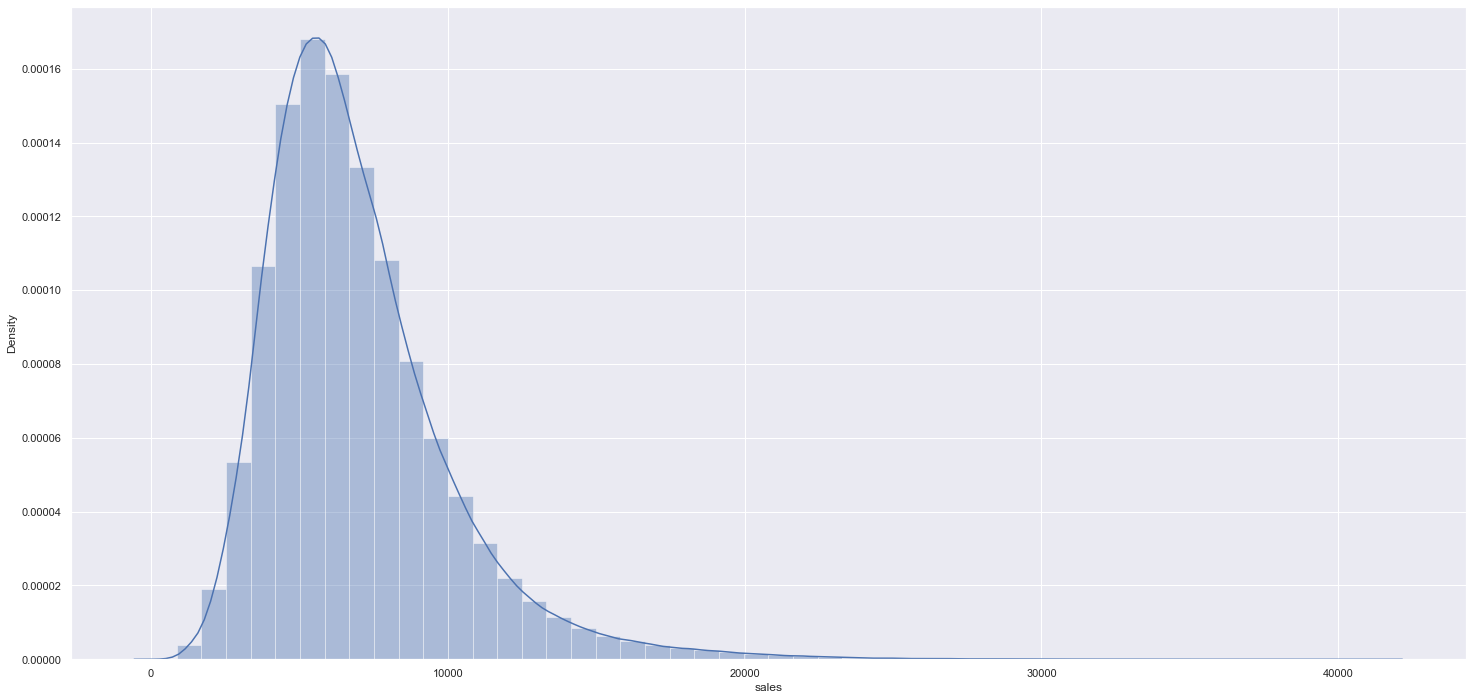

In [30]:
sns.distplot(df4['sales'])

### 4.1.2 Numerical  variable

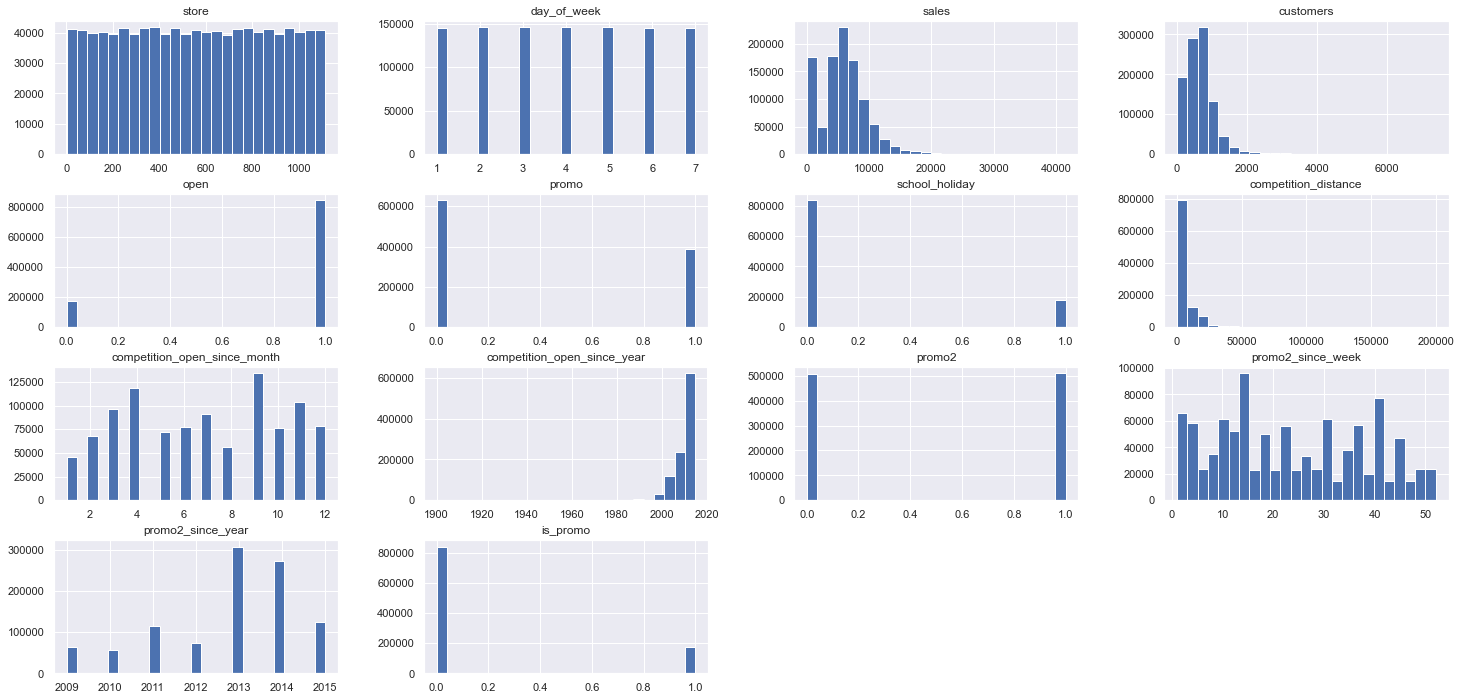

In [31]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical variable

In [32]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\vande\anaconda3\envs\ds-em-producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vande\anaconda3\envs\ds-em-producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vande\anaconda3\envs\ds-em-producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

<AxesSubplot:xlabel='sales', ylabel='Density'>

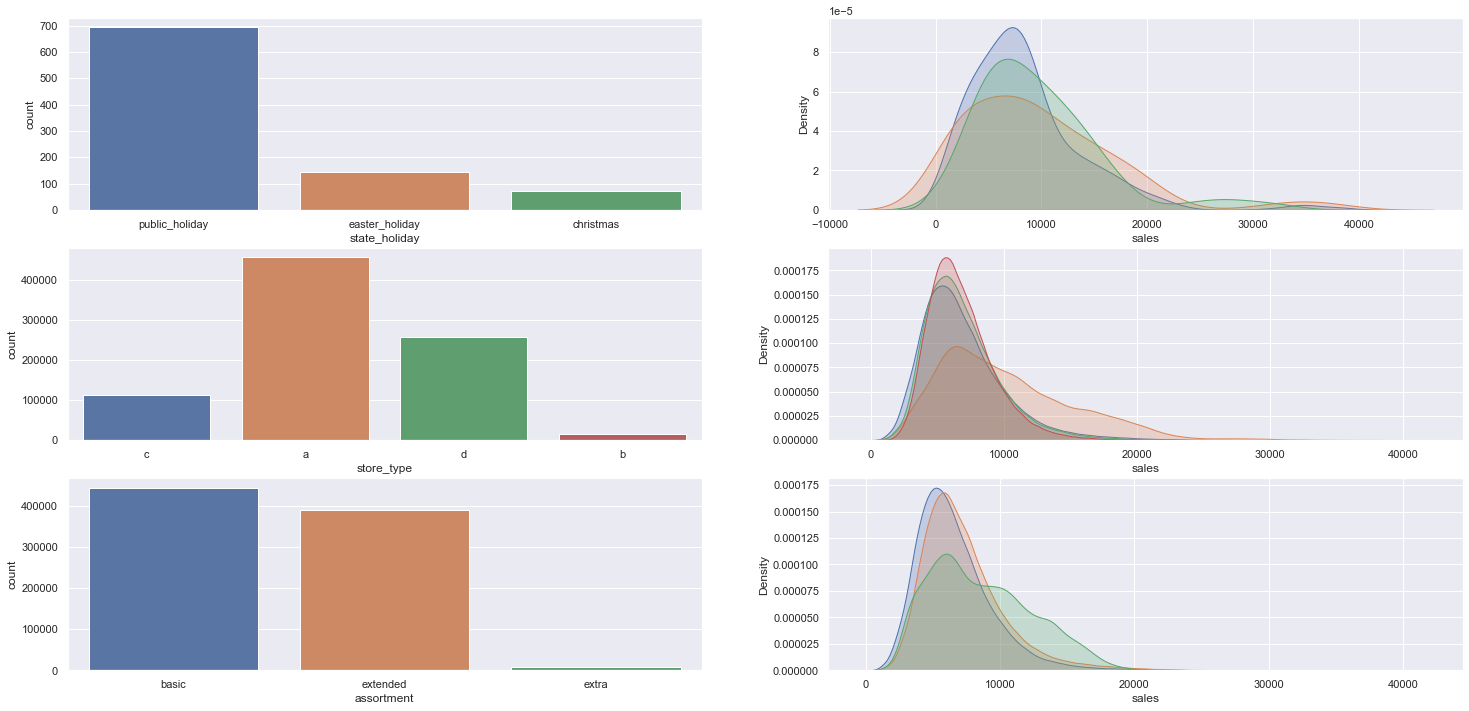

In [33]:
#state_holiday
plt.subplot(3,2,1) # linha, coluna, pos. graf
a= df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2) # linha, coluna, pos. graf
sns.kdeplot(df4[ df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[ df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[ df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)


#store_type
plt.subplot(3,2,3) # linha, coluna, pos. graf
sns.countplot(df4['store_type'])

plt.subplot(3,2,4) # linha, coluna, pos. graf
sns.kdeplot(df4[ df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[ df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[ df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[ df4['store_type'] == 'd']['sales'], label='d', shade=True)


#assorment

plt.subplot(3,2,5) # linha, coluna, pos. graf
sns.countplot(df4['assortment'])

plt.subplot(3,2,6) # linha, coluna, pos. graf
sns.kdeplot(df4[ df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[ df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[ df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


## 4.2 Analise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com SORTIMENTO MAIOR vendem MENOS


<AxesSubplot:xlabel='year_week'>

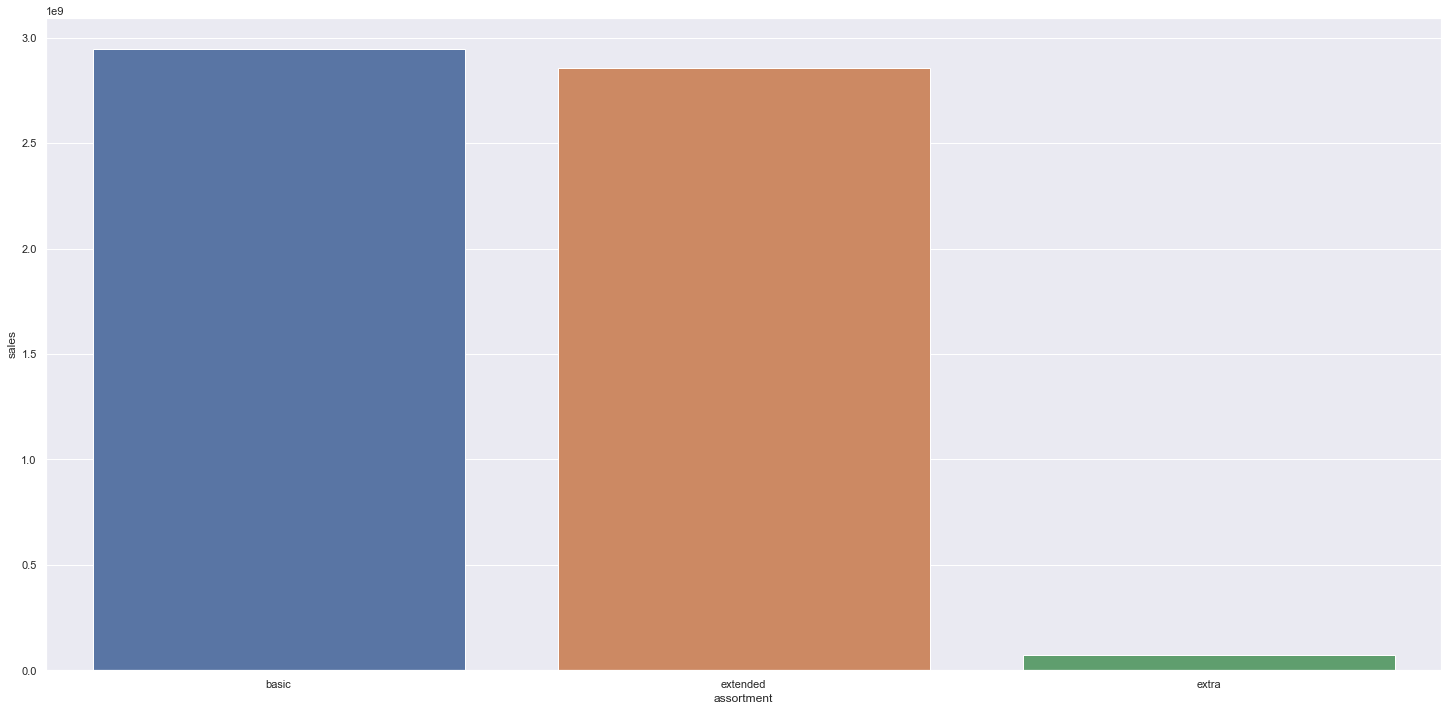

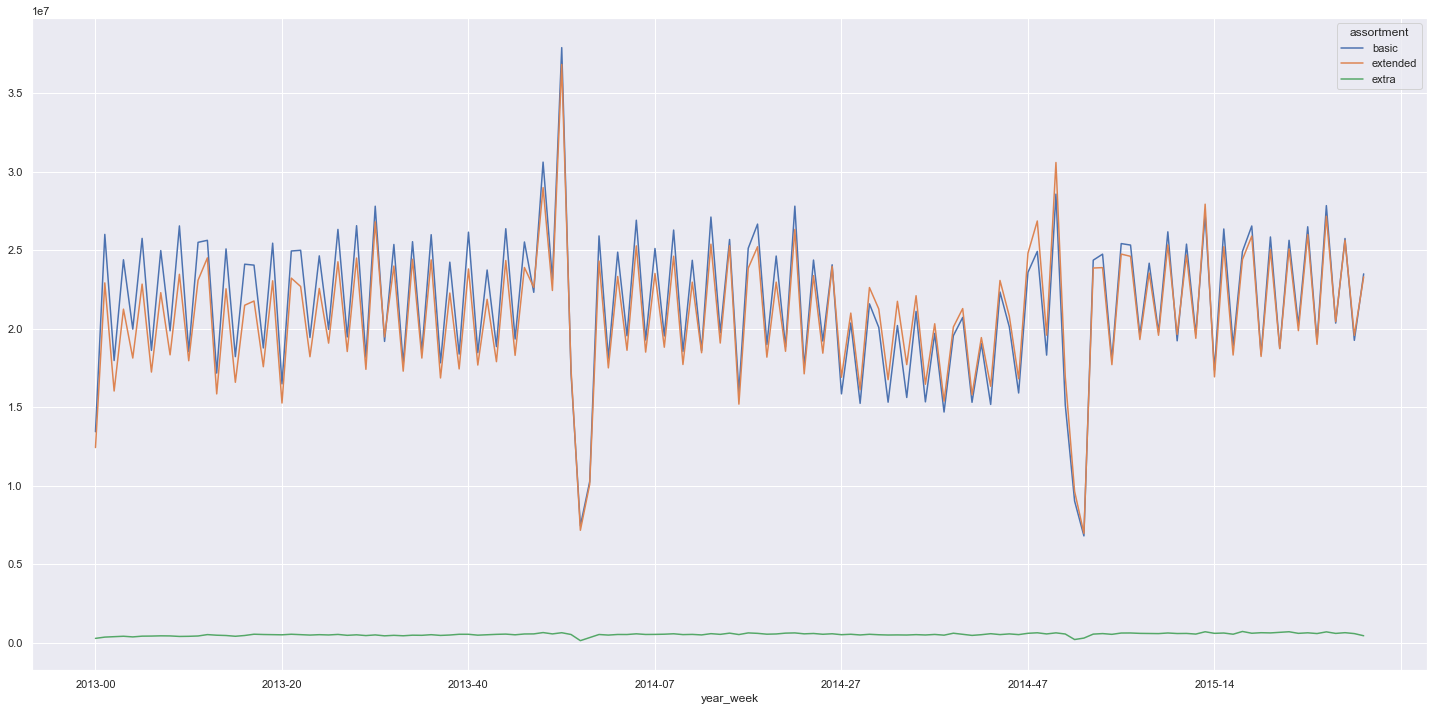

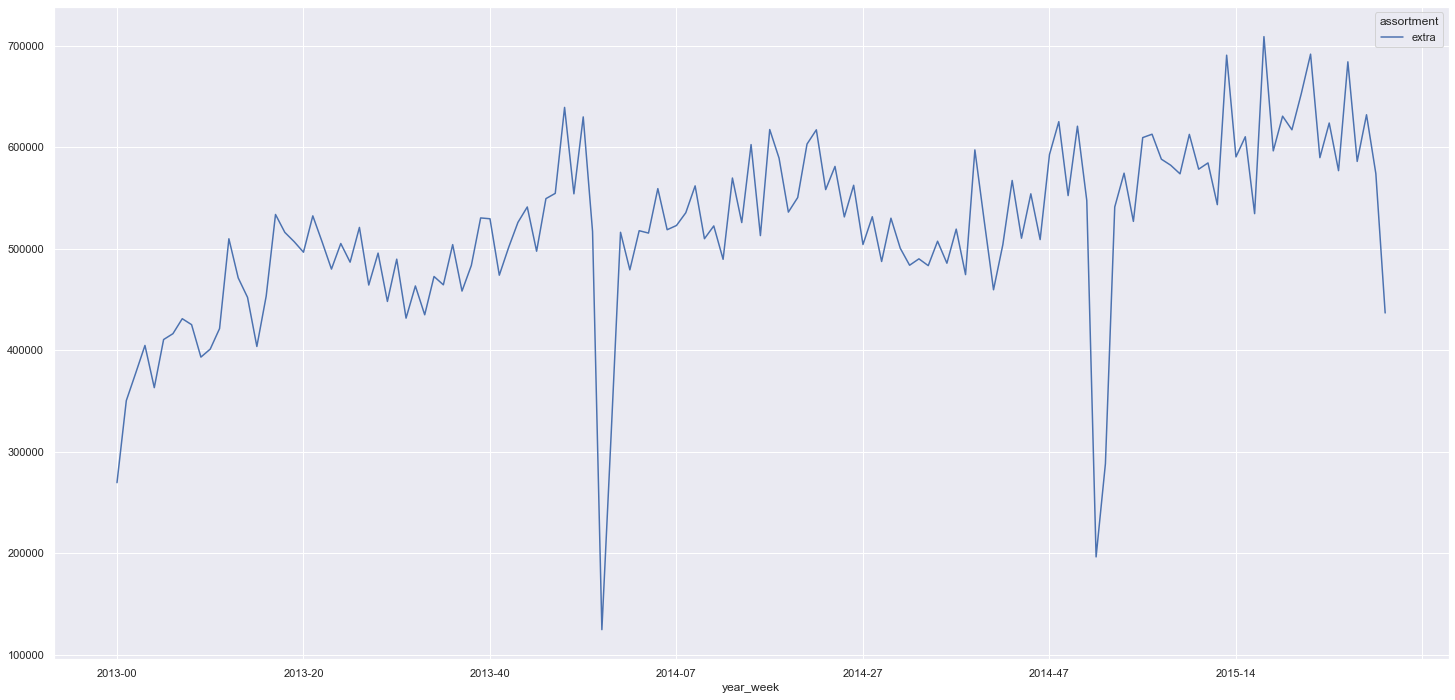

In [86]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( x= 'assortment' , y= 'sales' , data= aux1 );

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot(index='year_week' , columns='assortment' , values='sales' ).plot()
# sns.barplot( x= 'year_week' , y= 'sales' , data= aux3 );
aux3 = aux2[aux2['assortment'] =='extra']
aux3.pivot(index='year_week' , columns='assortment' , values='sales' ).plot()

### **H2** Lojas com competidores mais próximos deveriam vender menos.

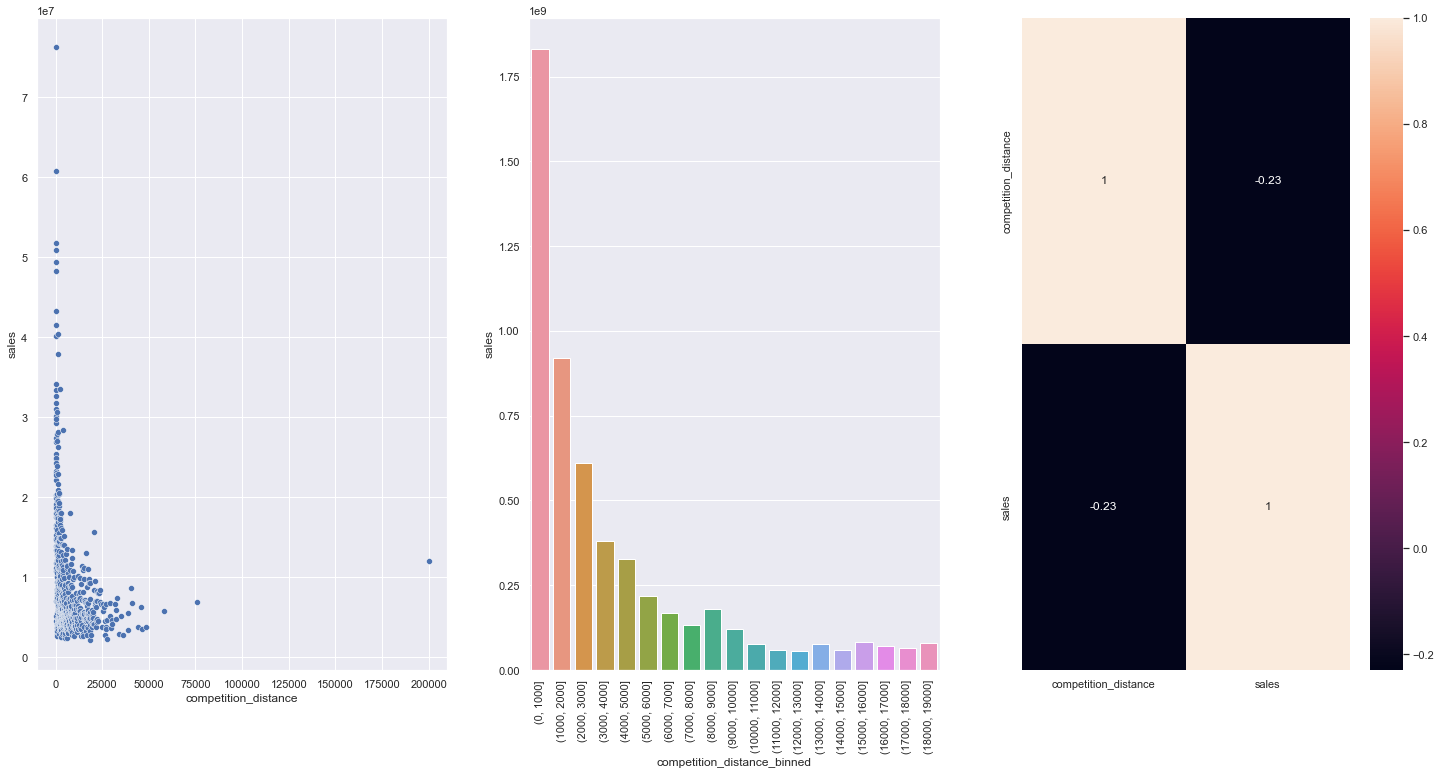

In [95]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x= 'competition_distance' , y='sales', data= aux1 )

plt.subplot(1, 3, 2)
bins = list( np.arange(0, 20000, 1000))
aux1['competition_distance_binned']  = pd.cut( aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x= 'competition_distance_binned' , y='sales' , data=aux2 )
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method = 'pearson' ),annot=True)


### **H3** Lojas com maior competidores a mais tempo deveriam vender mais.
**FALSA** Lojas com COMPETIDORES a MAIS TEMPO vendem MENOS

<AxesSubplot:>

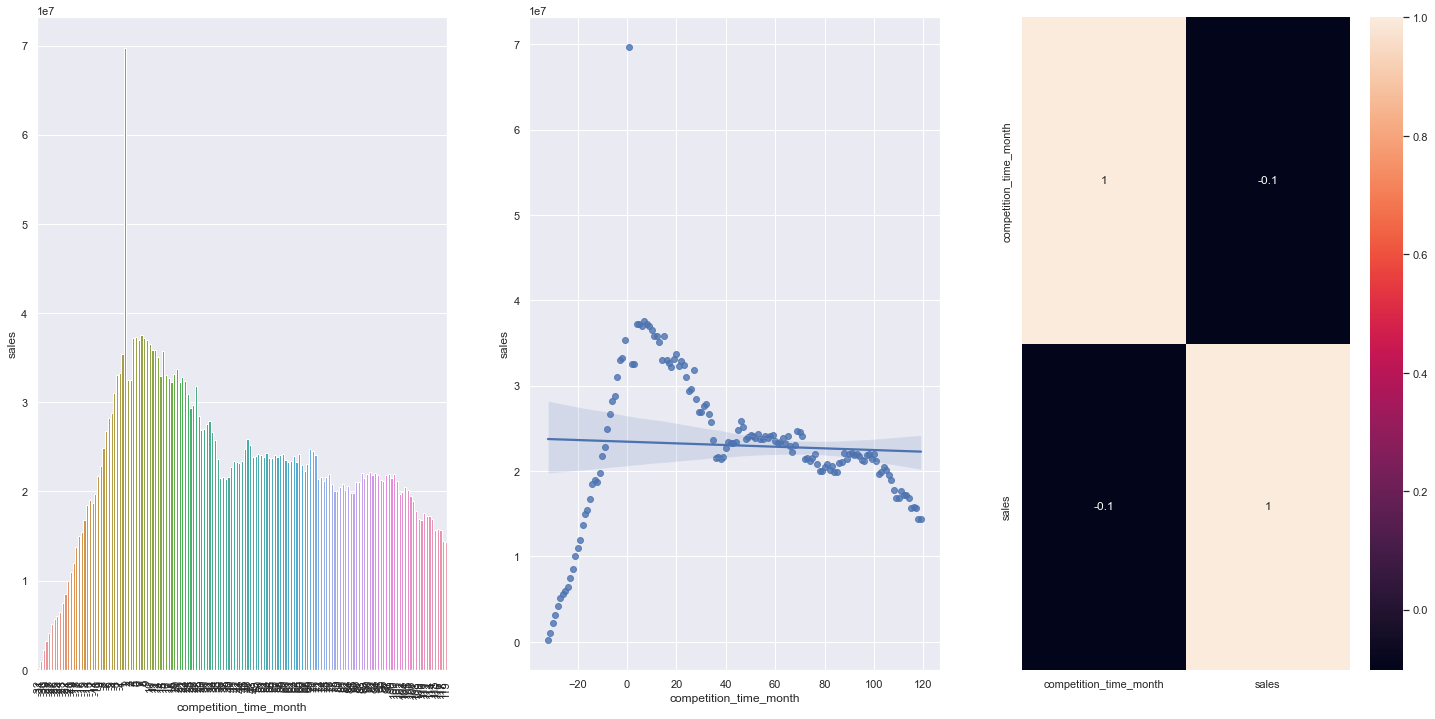

In [109]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

plt.subplot(1, 3, 1)
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


### H4 Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Pois lojas com promoções ativas por mais tempo vendem menos, depois de uma certo tempo.

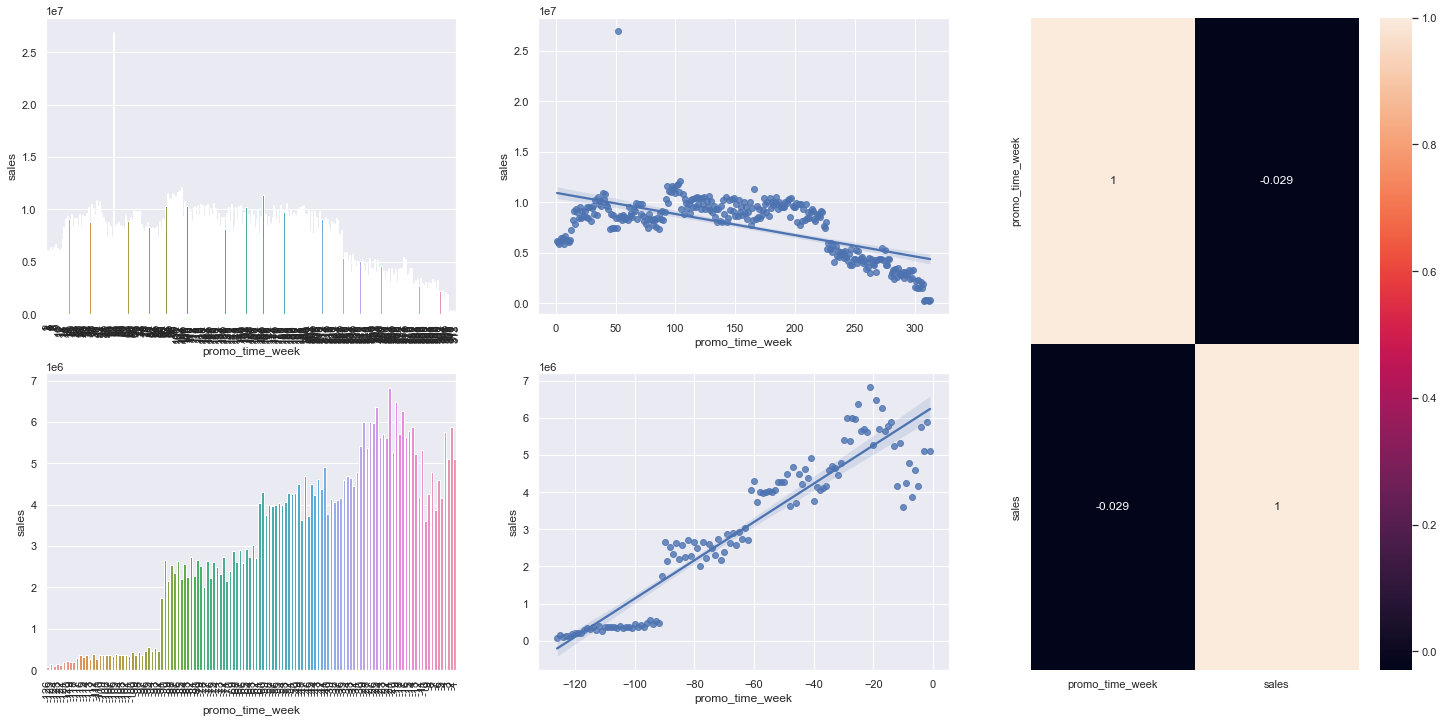

In [125]:
aux1= df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot(x='promo_time_week' , y= 'sales' , data= aux1)

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # periodo normal de promoção
sns.barplot(x='promo_time_week', y='sales', data= aux2)
plt.xticks(rotation=90);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # periodo extendido de promoção
sns.barplot(x='promo_time_week', y='sales', data= aux3)

plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data= aux2)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data= aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr( method='pearson'), annot= True);



### <s>H5 Lojas com mais dias de promoção deveriam vender mais.</s>

### H6 Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com promoções consecutivas vendem menos.


In [127]:
df4[['promo','promo2','sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


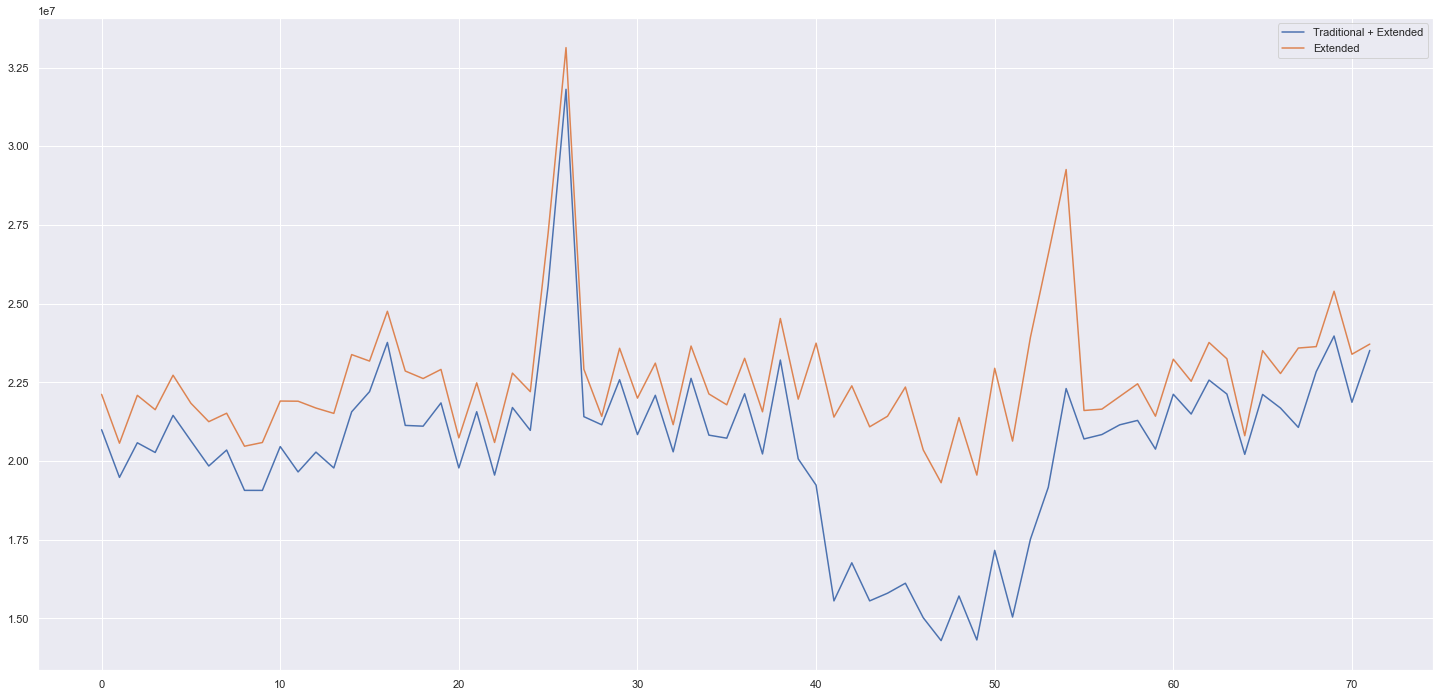

In [143]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Traditional + Extended', 'Extended']);


## 4.1 Analise Multivariada